# Set up

In [426]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math

# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [221]:
formula = \
'total_points ~ C(team) + C(opposition_team) + C(element_type) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [222]:
print(formula)

total_points ~ C(team) + C(opposition_team) + C(element_type) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [223]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [224]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [293]:
estimator = GradientBoostingRegressor(
    n_estimators=100,
    min_samples_leaf=0.129,
    learning_rate=0.0476,
    max_features=0.9,
    subsample=0.764

)

selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                          init=None, learning_rate=0.0476,
                                          loss='ls', max_depth=3,
                                          max_features=0.9, max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=0.129,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=100,
                                          n_iter_no_change=None, presort='auto',
                                          random_state=None, subsample=0.764,
                                          tol=0.0001, validation_fraction=0.1

In [294]:
sum(selector.support_)

35

In [399]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True])

In [295]:
list(pd.Series(X.design_info.column_names)[selector.support_])

['C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'value',
 'rolling_avg_total_points_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_attempt_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_concededd_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_minutes_el

In [296]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [475]:
space  = [
    Real(0.025, 0.027, 'uniform', name='min_samples_leaf'),
    Real(0.047, 0.049, 'uniform', name='learning_rate'),
#     Real(0.65, 0.75, 'uniform', name='max_features'),
#     Real(0.35, 0.45, 'uniform', name='subsample'),
#     Integer(2**6, 2**7, name='n_estimators')
]

In [476]:
gp_model = GradientBoostingRegressor(
    criterion='mse',
    n_estimators=120,
    max_features=0.7,
    subsample=0.4
)

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            X,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [478]:
res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=50, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6721
Function value obtained: 9.4276
Current minimum: 9.4276
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5485
Function value obtained: 9.4001
Current minimum: 9.4001
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5437
Function value obtained: 9.3854
Current minimum: 9.3854
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5459
Function value obtained: 9.4027
Current minimum: 9.3854
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5385
Function value obtained: 9.3399
Current minimum: 9.3399
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.0138
Function value obtained: 9.4081
Current minimum: 9.3121
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.0335
Function value obtained: 9.3865
Current minimum: 9.3121
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.1140
Function value obtained: 9.4071
Current minimum: 9.3121
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.0499
Function value obtained: 9.3233
Current minimum: 9.3121
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.0820
Function value obtained: 9.3294
Current minimum: 9.3121
Iteration No: 22 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.2451
Function value obtained: 9.3791
Current minimum: 9.3121
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.2795
Function value obtained: 9.3583
Current minimum: 9.3121
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.1114
Function value obtained: 9.3399
Current minimum: 9.3121
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.3224
Function value obtained: 9.4159
Current minimum: 9.3121
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.4182
Function value obtained: 9.4269
Current minimum: 9.3121
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.3265
Function value obtained: 9.4063
Current minimum: 9.3121
Iteration No: 32 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.4003
Function value obtained: 9.3795
Current minimum: 9.3121
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.4142
Function value obtained: 9.4342
Current minimum: 9.3121
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.4777
Function value obtained: 9.4661
Current minimum: 9.3121
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.4846
Function value obtained: 9.3203
Current minimum: 9.3121
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.3945
Function value obtained: 9.4652
Current minimum: 9.3121
Iteration No: 37 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.4196
Function value obtained: 9.3982
Current minimum: 9.3121
Iteration No: 42 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.3529
Function value obtained: 9.4034
Current minimum: 9.3121
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.5924
Function value obtained: 9.3733
Current minimum: 9.3121
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.6025
Function value obtained: 9.4032
Current minimum: 9.3121
Iteration No: 45 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.5552
Function value obtained: 9.4105
Current minimum: 9.3121
Iteration No: 46 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.5045
Function value obtained: 9.3788
Current minimum: 9.3121
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.4669
Function value obtained: 9.3324
Current minimum: 9.3121
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.4218
Function value obtained: 9.2981
Current minimum: 9.2981
Iteration No: 49 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.4569
Function value obtained: 9.3777
Current minimum: 9.2981
Iteration No: 50 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.4137
Function value obtained: 9.3254
Current minimum: 9.2981
minimisation iteration 2
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6000
Function value obtained: 9.3323
Current minimum: 9.3323
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5343
Function value obtained: 9.5681
Current minimum: 9.3323
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5297
Function value obtained: 9.4045
Current minimum: 9.3323
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5486
Function value obtained: 9.4423
Current minimum: 9.3323
Iteration No: 5 started. Evaluating function at random point

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.0873
Function value obtained: 9.4037
Current minimum: 9.3158
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.0930
Function value obtained: 9.3516
Current minimum: 9.3158
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.1793
Function value obtained: 9.3077
Current minimum: 9.3077
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.1100
Function value obtained: 9.3501
Current minimum: 9.3077
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.1154
Function value obtained: 9.2685
Current minimum: 9.2685
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.1688
Function value obtained: 9.4452
Current minimum: 9.2685
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.3606
Function value obtained: 9.3793
Current minimum: 9.2685
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.3553
Function value obtained: 9.3273
Current minimum: 9.2685
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.4028
Function value obtained: 9.3974
Current minimum: 9.2685
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.4114
Function value obtained: 9.3567
Current minimum: 9.2685
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.5011
Function value obtained: 9.4262
Current minimum: 9.2685
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.2988
Function value obtained: 9.4447
Current minimum: 9.2685
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.3629
Function value obtained: 9.3868
Current minimum: 9.2685
Iteration No: 31 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.2048
Function value obtained: 9.4035
Current minimum: 9.2685
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.3732
Function value obtained: 9.4046
Current minimum: 9.2685
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.3765
Function value obtained: 9.4336
Current minimum: 9.2685
Iteration No: 34 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.2694
Function value obtained: 9.3739
Current minimum: 9.2685
Iteration No: 35 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.2676
Function value obtained: 9.3178
Current minimum: 9.2685
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.4430
Function value obtained: 9.3473
Current minimum: 9.2685
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.2971
Function value obtained: 9.2881
Current minimum: 9.2685
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.3897
Function value obtained: 9.4428
Current minimum: 9.2685
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.2021
Function value obtained: 9.3641
Current minimum: 9.2685
Iteration No: 40 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.3373
Function value obtained: 9.4278
Current minimum: 9.2685
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.5015
Function value obtained: 9.3164
Current minimum: 9.2685
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.5418
Function value obtained: 9.4859
Current minimum: 9.2685
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.4493
Function value obtained: 9.4004
Current minimum: 9.2685
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.5775
Function value obtained: 9.4697
Current minimum: 9.2685
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.4095
Function value obtained: 9.4211
Current minimum: 9.2685
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.4895
Function value obtained: 9.4226
Current minimum: 9.2685
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.5493
Function value obtained: 9.3702
Current minimum: 9.2685
minimisation iteration 3
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5579
Function value obtained: 9.4494
Current minimum: 9.4494
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.9690
Function value obtained: 9.3805
Current minimum: 9.3200
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.0196
Function value obtained: 9.4420
Current minimum: 9.3200
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.9667
Function value obtained: 9.3457
Current minimum: 9.3200
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.9231
Function value obtained: 9.4213
Current minimum: 9.3200
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.1772
Function value obtained: 9.4405
Current minimum: 9.3200
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.1306
Function value obtained: 9.3990
Current minimum: 9.3200
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.0960
Function value obtained: 9.4210
Current minimum: 9.3200
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.1162
Function value obtained: 9.3440
Current minimum: 9.3200
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.3607
Function value obtained: 9.3773
Current minimum: 9.3200
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.1527
Function value obtained: 9.4309
Current minimum: 9.3200
Iteration No: 22 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.5726
Function value obtained: 9.3940
Current minimum: 9.2595
Iteration No: 41 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.6177
Function value obtained: 9.4144
Current minimum: 9.2595
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.5946
Function value obtained: 9.3976
Current minimum: 9.2595
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.3906
Function value obtained: 9.3493
Current minimum: 9.2595
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3529
Function value obtained: 9.4154
Current minimum: 9.2595
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.4306
Function value obtained: 9.3634
Current minimum: 9.2595
Iteration No: 46 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.4656
Function value obtained: 9.3533
Current minimum: 9.2595
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.6168
Function value obtained: 9.3137
Current minimum: 9.2595
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.6697
Function value obtained: 9.3797
Current minimum: 9.2595
minimisation iteration 4
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5307
Function value obtained: 9.3911
Current minimum: 9.3911
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5329
Function value obtained: 9.3499
Current minimum: 9.3499
Iteration No: 3 started. Evaluat

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.3571
Function value obtained: 9.3656
Current minimum: 9.2906
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.5138
Function value obtained: 9.3352
Current minimum: 9.2906
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.4156
Function value obtained: 9.3797
Current minimum: 9.2906
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.3950
Function value obtained: 9.3932
Current minimum: 9.2906
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.2132
Function value obtained: 9.4040
Current minimum: 9.2906
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.3912
Function value obtained: 9.4728
Current minimum: 9.2906
Iteration No: 32 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.2330
Function value obtained: 9.4124
Current minimum: 9.2906
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.6059
Function value obtained: 9.4077
Current minimum: 9.2906
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.5315
Function value obtained: 9.3983
Current minimum: 9.2906
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.7246
Function value obtained: 9.3920
Current minimum: 9.2906
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.2548
Function value obtained: 9.3549
Current minimum: 9.2906
Iteration No: 37 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.3657
Function value obtained: 9.3951
Current minimum: 9.2906
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.3913
Function value obtained: 9.3970
Current minimum: 9.2906
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.5200
Function value obtained: 9.3727
Current minimum: 9.2906
Iteration No: 44 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.2495
Function value obtained: 9.3541
Current minimum: 9.2906
Iteration No: 45 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.4214
Function value obtained: 9.3959
Current minimum: 9.2906
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.6583
Function value obtained: 9.3570
Current minimum: 9.2906
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.4162
Function value obtained: 9.3671
Current minimum: 9.2906
Iteration No: 48 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.5635
Function value obtained: 9.4179
Current minimum: 9.2906
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.3540
Function value obtained: 9.3486
Current minimum: 9.2906
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.3688
Function value obtained: 9.3137
Current minimum: 9.2906
minimisation iteration 5
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5597
Function value obtained: 9.3776
Current minimum: 9.3776
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5518
Function value obtained: 9.3187
Current minimum: 9.3187
Iteration No: 3 started. Evaluat

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.4378
Function value obtained: 9.3751
Current minimum: 9.3108
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.2046
Function value obtained: 9.3966
Current minimum: 9.3108
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.3232
Function value obtained: 9.3214
Current minimum: 9.3108
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.2036
Function value obtained: 9.3588
Current minimum: 9.3108
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.2307
Function value obtained: 9.3458
Current minimum: 9.3108
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.3636
Function value obtained: 9.3849
Current minimum: 9.3108
Iteration No: 29 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.2708
Function value obtained: 9.3643
Current minimum: 9.3108
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.2341
Function value obtained: 9.3176
Current minimum: 9.3108
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.2022
Function value obtained: 9.4199
Current minimum: 9.3108
Iteration No: 36 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.4144
Function value obtained: 9.3176
Current minimum: 9.3108
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.4644
Function value obtained: 9.3407
Current minimum: 9.3108
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.4010
Function value obtained: 9.3887
Current minimum: 9.3108
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.3484
Function value obtained: 9.2910
Current minimum: 9.2910
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.4995
Function value obtained: 9.4014
Current minimum: 9.2910
Iteration No: 41 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.8342
Function value obtained: 9.3369
Current minimum: 9.2910
Iteration No: 46 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.5890
Function value obtained: 9.3691
Current minimum: 9.2910
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.3693
Function value obtained: 9.4091
Current minimum: 9.2910
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.3918
Function value obtained: 9.3089
Current minimum: 9.2910
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.3338
Function value obtained: 9.2856
Current minimum: 9.2856
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.6039
Function value obtained: 9.4229
Current minimum: 9.2856


In [479]:
# Full features
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.298119880883927
9.268538113922633
9.259453571337799
9.290594192771708
9.285606770797818


[0.02682671492411723, 0.04899947978532798]
[0.025, 0.047]
[0.025029512991292212, 0.04700963040137121]
[0.026699781611265308, 0.04797975983826205]
[0.025, 0.047]


### Grid search

#### Leaf size

In [496]:
np.linspace(-8, -1, 15)

array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. ,
       -2.5, -2. , -1.5, -1. ])

In [497]:
gs_parameters_ls = {
    'min_samples_leaf': [2**i for i in np.linspace(-8, -1, 15)],
    'learning_rate': [0.0470],
    'max_features': [0.7],
    'subsample': [0.4],
    'n_estimators': [120]
}

In [498]:
gs_model_df_arr_ls = []
for i in range(0, 100):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=100),
        gs_parameters_ls,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
        'param_max_features',
        'param_subsample',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_ls.append(gs_model_df)

In [499]:
gs_model_df_ls = pd.concat(gs_model_df_arr_ls)

gs_model_df_ls['param_min_samples_leaf_log'] = \
gs_model_df_ls['param_min_samples_leaf'].apply(lambda x: math.log(x, 2))

gs_model_df_ls_group = \
gs_model_df_ls.groupby('param_min_samples_leaf_log')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_ls_group.reset_index(inplace=True)
gs_model_df_ls_group

,param_min_samples_leaf_log,count,mean,std,min,25%,50%,75%,max
0,-8.0,100.0,-9.424301,0.047348,-9.524535,-9.458637,-9.430240,-9.388436,-9.321850
1,-7.5,100.0,-9.416293,0.050549,-9.544291,-9.451197,-9.422482,-9.379891,-9.289887
2,-7.0,100.0,-9.395638,0.043772,-9.496044,-9.424072,-9.395754,-9.365349,-9.294441
3,-6.5,100.0,-9.398716,0.046390,-9.521100,-9.428629,-9.400822,-9.362039,-9.312325
4,-6.0,100.0,-9.397211,0.048209,-9.517281,-9.433260,-9.403606,-9.361815,-9.286859
5,-5.5,100.0,-9.373843,0.044703,-9.473863,-9.404053,-9.373944,-9.342766,-9.232974
6,-5.0,100.0,-9.383332,0.043032,-9.470692,-9.415953,-9.383357,-9.355710,-9.272821
7,-4.5,100.0,-9.389401,0.032866,-9.472558,-9.410709,-9.386965,-9.367559,-9.311267
8,-4.0,100.0,-9.385574,0.029046,-9.455234,-9.404320,-9.386386,-9.368676,-9.318231
9,-3.5,100.0,-9.420919,0.024489,-9.473414,-9.438350,-9.420895,-9.406792,-9.362156


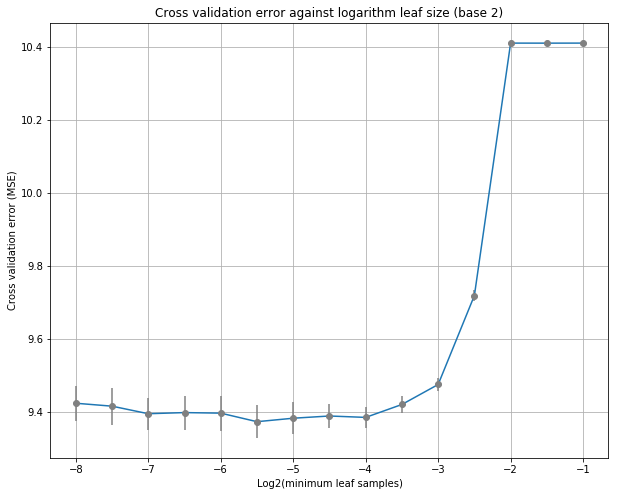

In [655]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_ls_group['param_min_samples_leaf_log'],
    -gs_model_df_ls_group['mean']
)
plt.errorbar(
    gs_model_df_ls_group['param_min_samples_leaf_log'],
    -gs_model_df_ls_group['mean'],
    yerr=gs_model_df_ls_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against logarithm leaf size (base 2)')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Log2(minimum leaf samples)')
plt.grid()
plt.show()

#### Learning rate

In [501]:
gs_parameters_lr = {
    'min_samples_leaf': [0.025],
    'learning_rate': [2**i for i in np.linspace(-8, -1, 15)],
    'max_features': [0.7],
    'subsample': [0.4],
    'n_estimators': [120]
}

In [502]:
gs_model_df_arr_lr = []
for i in range(0, 100):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=100),
        gs_parameters_lr,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1, verbose=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
        'param_max_features',
        'param_subsample',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_lr.append(gs_model_df)

Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 15 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished


In [503]:
gs_model_df_lr = pd.concat(gs_model_df_arr_lr)

gs_model_df_lr['param_learning_rate_log'] = \
gs_model_df_lr['param_learning_rate'].apply(lambda x: math.log(x, 2))

gs_model_df_lr_group = \
gs_model_df_lr.groupby('param_learning_rate_log')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_lr_group.reset_index(inplace=True)
gs_model_df_lr_group

,param_learning_rate_log,count,mean,std,min,25%,50%,75%,max
0,-8.0,100.0,-9.907692,0.008192,-9.928743,-9.912859,-9.907937,-9.904237,-9.888413
1,-7.5,100.0,-9.781113,0.009303,-9.805737,-9.787031,-9.780456,-9.776077,-9.757899
2,-7.0,100.0,-9.651522,0.010987,-9.671524,-9.659482,-9.653937,-9.645042,-9.613043
3,-6.5,100.0,-9.525557,0.015107,-9.556488,-9.537741,-9.524946,-9.515697,-9.485812
4,-6.0,100.0,-9.434876,0.018683,-9.488572,-9.446547,-9.433092,-9.422942,-9.388725
5,-5.5,100.0,-9.376598,0.024815,-9.432156,-9.390747,-9.377443,-9.362213,-9.321523
6,-5.0,100.0,-9.363012,0.030845,-9.477035,-9.380968,-9.362126,-9.343824,-9.268859
7,-4.5,100.0,-9.376038,0.041762,-9.499880,-9.400164,-9.377885,-9.346273,-9.272002
8,-4.0,100.0,-9.406490,0.054540,-9.588259,-9.448431,-9.400250,-9.376508,-9.242388
9,-3.5,100.0,-9.461459,0.069904,-9.650913,-9.499830,-9.457591,-9.415974,-9.299945


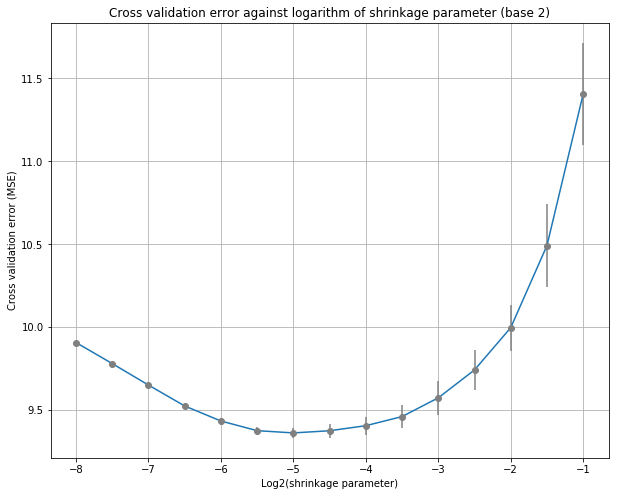

In [661]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_lr_group['param_learning_rate_log'],
    -gs_model_df_lr_group['mean']
)
plt.errorbar(
    gs_model_df_lr_group['param_learning_rate_log'],
    -gs_model_df_lr_group['mean'],
    yerr=gs_model_df_lr_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against logarithm of shrinkage parameter (base 2)')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Log2(shrinkage parameter)')
# plt.ylim(9.3, 10.4)
plt.grid()
plt.show()

#### Number of features

In [505]:
gs_parameters_nf = {
    'min_samples_leaf': [0.025],
    'learning_rate': [0.047],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.4],
    'n_estimators': [120]
}

In [506]:
gs_model_df_arr_nf = []
for i in range(0, 100):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=100),
        gs_parameters_nf,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1, verbose=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
        'param_max_features',
        'param_subsample',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_nf.append(gs_model_df)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


In [507]:
gs_model_df_nf = pd.concat(gs_model_df_arr_nf)

gs_model_df_nf_group = \
gs_model_df_nf.groupby('param_max_features')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_nf_group.reset_index(inplace=True)
gs_model_df_nf_group

,param_max_features,count,mean,std,min,25%,50%,75%,max
0,0.1,100.0,-9.399910,0.031586,-9.479044,-9.423492,-9.396114,-9.378107,-9.334154
1,0.2,100.0,-9.374648,0.042647,-9.471568,-9.403906,-9.371264,-9.348187,-9.276496
2,0.3,100.0,-9.379124,0.039660,-9.459079,-9.407341,-9.377899,-9.353721,-9.287770
3,0.4,100.0,-9.384164,0.043496,-9.490932,-9.412727,-9.383558,-9.359448,-9.252391
4,0.5,100.0,-9.373227,0.038087,-9.455225,-9.401921,-9.369393,-9.350472,-9.270205
5,0.6,100.0,-9.375857,0.038191,-9.476545,-9.405181,-9.379922,-9.353595,-9.267513
6,0.7,100.0,-9.374399,0.039414,-9.485835,-9.396735,-9.372739,-9.346840,-9.287233
7,0.8,100.0,-9.380788,0.043553,-9.506536,-9.410322,-9.378765,-9.352460,-9.259620
8,0.9,100.0,-9.376673,0.044183,-9.478675,-9.407167,-9.373286,-9.349725,-9.268443
9,1.0,100.0,-9.373181,0.033658,-9.454108,-9.401829,-9.374468,-9.341605,-9.305302


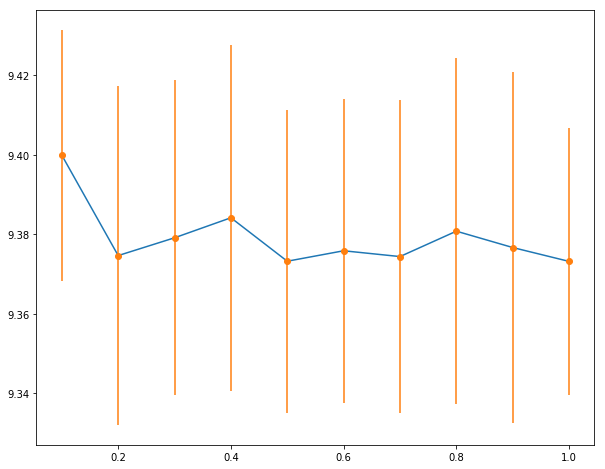

In [508]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_nf_group['param_max_features'],
    -gs_model_df_nf_group['mean']
)
plt.errorbar(
    gs_model_df_nf_group['param_max_features'],
    -gs_model_df_nf_group['mean'],
    yerr=gs_model_df_nf_group['std'], fmt='o')
plt.show()

#### Subsample

In [509]:
gs_parameters_ss = {
    'min_samples_leaf': [0.025],
    'learning_rate': [0.047],
    'max_features': [0.7],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [120]
}

In [510]:
gs_model_df_arr_ss = []
for i in range(0, 100):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=100),
        gs_parameters_ss,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1, verbose=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
        'param_max_features',
        'param_subsample',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_ss.append(gs_model_df)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


In [511]:
gs_model_df_ss = pd.concat(gs_model_df_arr_ss)

gs_model_df_ss_group = \
gs_model_df_ss.groupby('param_subsample')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_ss_group.reset_index(inplace=True)
gs_model_df_ss_group

,param_subsample,count,mean,std,min,25%,50%,75%,max
0,0.1,100.0,-9.463335,0.046210,-9.607316,-9.487677,-9.465938,-9.426955,-9.341366
1,0.2,100.0,-9.404886,0.046668,-9.543292,-9.433312,-9.407268,-9.377300,-9.293425
2,0.3,100.0,-9.389200,0.046906,-9.505200,-9.418714,-9.393806,-9.359779,-9.279374
3,0.4,100.0,-9.370075,0.046048,-9.495984,-9.393982,-9.371031,-9.338862,-9.217315
4,0.5,100.0,-9.376442,0.031080,-9.449926,-9.395993,-9.372468,-9.359410,-9.302010
5,0.6,100.0,-9.389163,0.036315,-9.477234,-9.411626,-9.389006,-9.365223,-9.279500
6,0.7,100.0,-9.385694,0.029628,-9.454435,-9.404622,-9.384426,-9.364876,-9.317863
7,0.8,100.0,-9.404662,0.031216,-9.477206,-9.423790,-9.410823,-9.380579,-9.330145
8,0.9,100.0,-9.406862,0.030897,-9.492316,-9.428532,-9.407695,-9.384180,-9.334323
9,1.0,100.0,-9.437788,0.018778,-9.481959,-9.452323,-9.437406,-9.425606,-9.390336


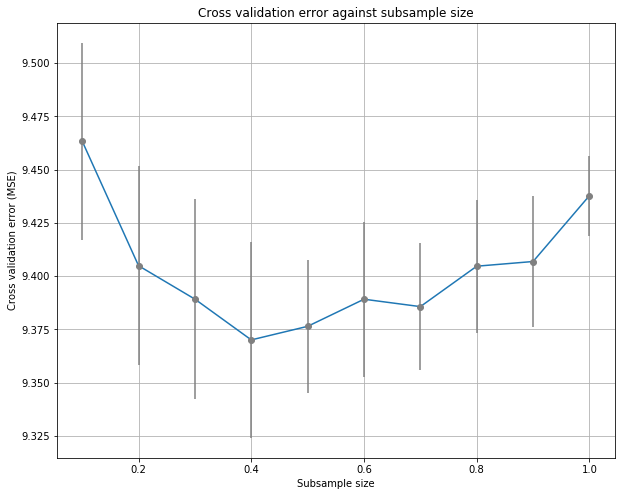

In [667]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_ss_group['param_subsample'],
    -gs_model_df_ss_group['mean']
)
plt.errorbar(
    gs_model_df_ss_group['param_subsample'],
    -gs_model_df_ss_group['mean'],
    yerr=gs_model_df_ss_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against subsample size')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Subsample size')
# plt.ylim(9.3, 10.4)
plt.grid()
plt.show()

#### Number of trees

In [547]:
gs_parameters_nt = {
    'min_samples_leaf': [0.025],
    'learning_rate': [0.047],
    'max_features': [0.7],
    'subsample': [0.4],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
}

In [514]:
gs_model_df_arr_nt = []
for i in range(0, 100):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            n_estimators=100),
        gs_parameters_nt,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1, verbose=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
        'param_max_features',
        'param_subsample',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_nt.append(gs_model_df)

Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 11 candidates, totalling 11 fits


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    5.5s finished


In [515]:
gs_model_df_nt = pd.concat(gs_model_df_arr_nt)

gs_model_df_nt['param_n_estimators_log'] = \
gs_model_df_nt['param_n_estimators'].apply(lambda x: math.log(x, 2))

gs_model_df_nt_group = \
gs_model_df_nt.groupby('param_n_estimators_log')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_nt_group.reset_index(inplace=True)
gs_model_df_nt_group

,param_n_estimators_log,count,mean,std,min,25%,50%,75%,max
0,0.0,100.0,-10.343590,0.012484,-10.373970,-10.352548,-10.342092,-10.336085,-10.314849
1,1.0,100.0,-10.276655,0.016098,-10.324136,-10.286436,-10.277452,-10.266400,-10.227088
2,2.0,100.0,-10.168002,0.021071,-10.216362,-10.181617,-10.167634,-10.155020,-10.116665
3,3.0,100.0,-9.983816,0.026463,-10.045487,-9.999696,-9.985103,-9.967576,-9.882054
4,4.0,100.0,-9.738726,0.028666,-9.797604,-9.760431,-9.737674,-9.718036,-9.661709
5,5.0,100.0,-9.501798,0.031136,-9.574717,-9.521851,-9.502978,-9.479065,-9.430094
6,6.0,100.0,-9.377744,0.036739,-9.471739,-9.400039,-9.377488,-9.352008,-9.284817
7,7.0,100.0,-9.382811,0.043236,-9.500832,-9.413647,-9.379863,-9.354657,-9.283588
8,8.0,100.0,-9.445586,0.059881,-9.585348,-9.482951,-9.447712,-9.406420,-9.303778
9,9.0,100.0,-9.528552,0.056325,-9.674973,-9.566141,-9.522539,-9.486855,-9.415289


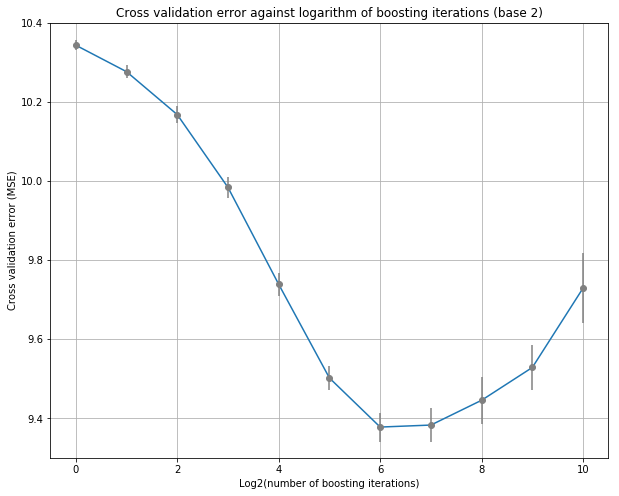

In [658]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_nt_group['param_n_estimators_log'],
    -gs_model_df_nt_group['mean']
)
plt.errorbar(
    gs_model_df_nt_group['param_n_estimators_log'],
    -gs_model_df_nt_group['mean'],
    yerr=gs_model_df_nt_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against logarithm of boosting iterations (base 2)')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Log2(number of boosting iterations)')
plt.ylim(9.3, 10.4)
plt.grid()
plt.show()

#### All

In [668]:
?GradientBoostingRegressor

In [673]:
gs_parameters_all = {
    'min_samples_leaf': [0.01, 0.04, 0.16],
    'learning_rate': [0.01, 0.04, 0.16],
    'subsample': [0.25, 0.5, 0.75, 1.0],
    'n_estimators': [50, 100, 150, 200],
}

In [675]:
gs_model_df_arr_all = []
for i in range(0, 10):
    gs_model = GridSearchCV(
        GradientBoostingRegressor(
            criterion='mse',
            loss='ls',
            max_features=1.0, 
            max_depth=10
        ),
        gs_parameters_all,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1, verbose=1)
    gs_model.fit(X_sel, y.ravel())
    
    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_learning_rate',
#         'param_max_features',
        'param_subsample',
        'param_n_estimators',
#         'param_loss',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error']]


    gs_model_df_arr_all.append(gs_model_df)

Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 144 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.0min finished


In [676]:
gs_model_df_all = pd.concat(gs_model_df_arr_all)
gs_model_df_all_group = gs_model_df_all.groupby([
    'param_min_samples_leaf',
    'param_learning_rate',
#     'param_max_features',
    'param_subsample',
    'param_n_estimators',
#     'param_loss'
])['split0_test_neg_mean_squared_error'].describe().reset_index()

In [679]:
gs_model_df_all_group[gs_model_df_all_group['mean'] > -9.5]
# gs_model_df_all_group

,param_min_samples_leaf,param_learning_rate,param_subsample,param_n_estimators,count,mean,std,min,25%,50%,75%,max
2,0.01,0.01,0.25,150,10.0,-9.414542,2.300488e-02,-9.449814,-9.426880,-9.413682,-9.402690,-9.377000
3,0.01,0.01,0.25,200,10.0,-9.376744,4.224939e-02,-9.419925,-9.409154,-9.384368,-9.356921,-9.290738
5,0.01,0.01,0.50,100,10.0,-9.491325,3.044410e-02,-9.552847,-9.504167,-9.488148,-9.468497,-9.452546
6,0.01,0.01,0.50,150,10.0,-9.393695,2.400394e-02,-9.437603,-9.411171,-9.387970,-9.374710,-9.367129
7,0.01,0.01,0.50,200,10.0,-9.387276,2.383192e-02,-9.422547,-9.404358,-9.389575,-9.367444,-9.353504
9,0.01,0.01,0.75,100,10.0,-9.497285,2.334717e-02,-9.537460,-9.507916,-9.492949,-9.481490,-9.464269
10,0.01,0.01,0.75,150,10.0,-9.415427,1.628079e-02,-9.438616,-9.426376,-9.417570,-9.409197,-9.384452
11,0.01,0.01,0.75,200,10.0,-9.390667,2.210348e-02,-9.429776,-9.401536,-9.388962,-9.379434,-9.353381
14,0.01,0.01,1.00,150,10.0,-9.469685,0.000000e+00,-9.469685,-9.469685,-9.469685,-9.469685,-9.469685
15,0.01,0.01,1.00,200,10.0,-9.443377,1.324018e-15,-9.443377,-9.443377,-9.443377,-9.443377,-9.443377


# Evaluating model

## Gradient boosted trees

In [641]:
test_loss_arr = []
for i in range(0, 100):
    model = GradientBoostingRegressor(
        criterion='mse',
        min_samples_leaf=0.0175,
        max_features=1.0,
        learning_rate=0.02,
        subsample=0.3,
        n_estimators=200
    )

    model.fit(X_train, y_train.ravel())
    
    # get predictions for test set
    y_pred = model.predict(X_test).flatten()

    # calculate cross entropy loss for test set
    test_loss = (
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    )
    test_loss_arr.append(test_loss)

In [666]:
test_loss = \
[np.mean([i[j] for i in test_loss_arr]) for j in range(0, 3)]

test_loss_std = \
[np.std([i[j] for i in test_loss_arr]) for j in range(0, 3)]


test_loss, test_loss_std

([2.167331487948851, 9.344370664720897, 0.1020917602977927],
 [0.006347698686697918, 0.029026017078353106, 0.002789133782844077])

In [643]:
test_loss_full_arr = []
for i in range(0, 100):
    model_full = GradientBoostingRegressor(
        criterion='mse',
        min_samples_leaf=0.0175,
        max_features=1.0,
        learning_rate=0.02,
        subsample=0.3,
        n_estimators=200
    )

    model_full.fit(X, y.ravel())
    
    # get predictions for test set
    y_pred_full = model_full.predict(X).flatten()

    # calculate cross entropy loss for test set
    test_loss_full = (
        mean_absolute_error(y, y_pred_full),
        mean_squared_error(y, y_pred_full),
        r2_score(y, y_pred_full)
    )
    test_loss_full_arr.append(test_loss_full)

In [644]:
test_loss_full = \
[np.mean([i[j] for i in test_loss_full_arr]) for j in range(0, 3)]

test_loss_full

[2.072680734332628, 8.080772265364082, 0.15548685580309804]

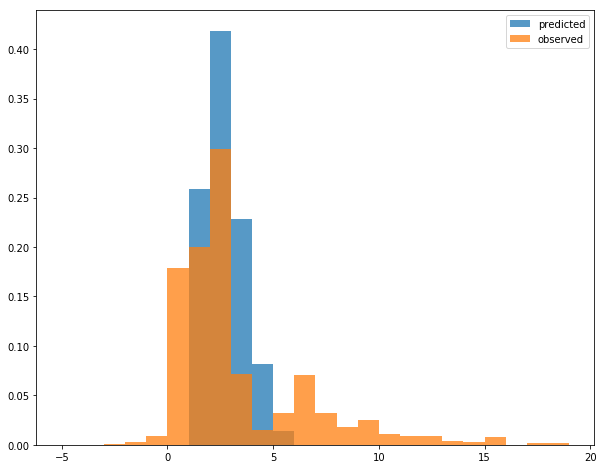

In [645]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

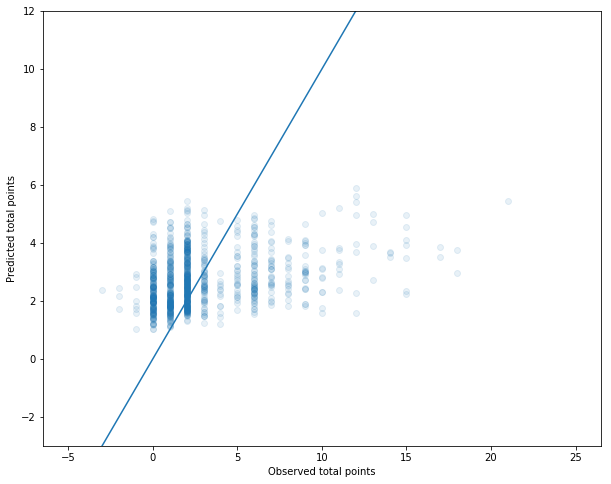

In [646]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [647]:
pd.DataFrame([
    ('Gradient boosted tree', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Gradient boosted tree,2.167331,9.344371,0.102092


In [648]:
pd.DataFrame([
    ('Gradient boosted tree', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Gradient boosted tree,2.072681,8.080772,0.155487
